In [1]:
import pandas as pd
import numpy as np
import random
from faker import Faker
from datetime import datetime, timedelta

In [2]:
fake = Faker()

In [3]:
transaction_types = ['Online Purchase', 'ATM Withdrawal', 'POS Purchase', 'Wire Transfer']
merchants = ['Amazon', 'Walmart', 'Target', 'PayPal', 'BestBuy', 'Uber', 'Netflix']
locations = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Miami', 'San Francisco']

In [4]:
def generate_transactions(num_transactions=1000000, fraud_ratio=0.075):
    transactions = []

    for _ in range(num_transactions):
        fraud = random.random() < fraud_ratio  # Determine if transaction is fraudulent
        transaction = {
            "Transaction ID": fake.uuid4(),
            "Timestamp": fake.date_time_between(start_date="-1y", end_date="now"),
            "Amount": round(random.uniform(10, 5000), 2) if not fraud else round(random.uniform(5000, 20000), 2),
            "Merchant": random.choice(merchants),
            "Location": random.choice(locations),
            "Transaction Type": random.choice(transaction_types),
            "Fraudulent": 1 if fraud else 0
        }
        transactions.append(transaction)

    return transactions

In [5]:
df = pd.DataFrame(generate_transactions(1000000, 0.075))

In [6]:
df.head()

Transaction ID                  Timestamp   Amount  \
0  ae4ef6ed-8cab-45a1-ac0c-72eda1026a22 2024-12-12 08:03:51.682416  3934.68   
1  a39d2a7c-aad2-4e4d-a77a-5bea8a93195a 2024-07-11 09:42:53.622417  2648.68   
2  2a8161da-b7e2-4f2b-a6b2-17a654940254 2025-01-15 04:00:49.266556  2588.49   
3  d7243438-7d76-4c22-b282-20e11d9f5055 2024-04-30 09:13:30.169783  3611.51   
4  f413ca3a-8613-4ef3-b71a-06bf60c44cb6 2024-04-16 09:29:43.467236  2668.53   

  Merchant     Location Transaction Type  Fraudulent  
0   Amazon      Chicago  Online Purchase           0  
1   PayPal      Chicago     POS Purchase           0  
2  BestBuy        Miami    Wire Transfer           0  
3  BestBuy     New York     POS Purchase           0  
4   Amazon  Los Angeles    Wire Transfer           0

In [7]:
!pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

In [9]:
df = df.drop(columns=["Transaction ID", "Timestamp"])

In [10]:
categorical_columns = ["Merchant", "Location", "Transaction Type"]
label_encoders = {}

In [11]:
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le 

In [12]:
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])

In [13]:
X = df.drop(columns=["Fraudulent"])  
y = df["Fraudulent"]

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = IsolationForest(contamination=0.075, random_state=42)
model.fit(X_train) 

IsolationForest(contamination=0.075, random_state=42)

In [17]:
y_pred = model.predict(X_test)

In [18]:
y_pred = np.where(y_pred == -1, 1, 0)

## Converts Isolation Forest outputs (-1 for anomaly, 1 for normal) to 1 (fraud) and 0 (normal).

In [19]:
!pip install seaborn matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9681
Precision: 0.8836
Recall: 0.8842
F1-score: 0.8839


In [21]:
X_test["Fraudulent"] = y_test.values  # Actual fraud labels
X_test["Predicted Fraud"] = y_pred

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

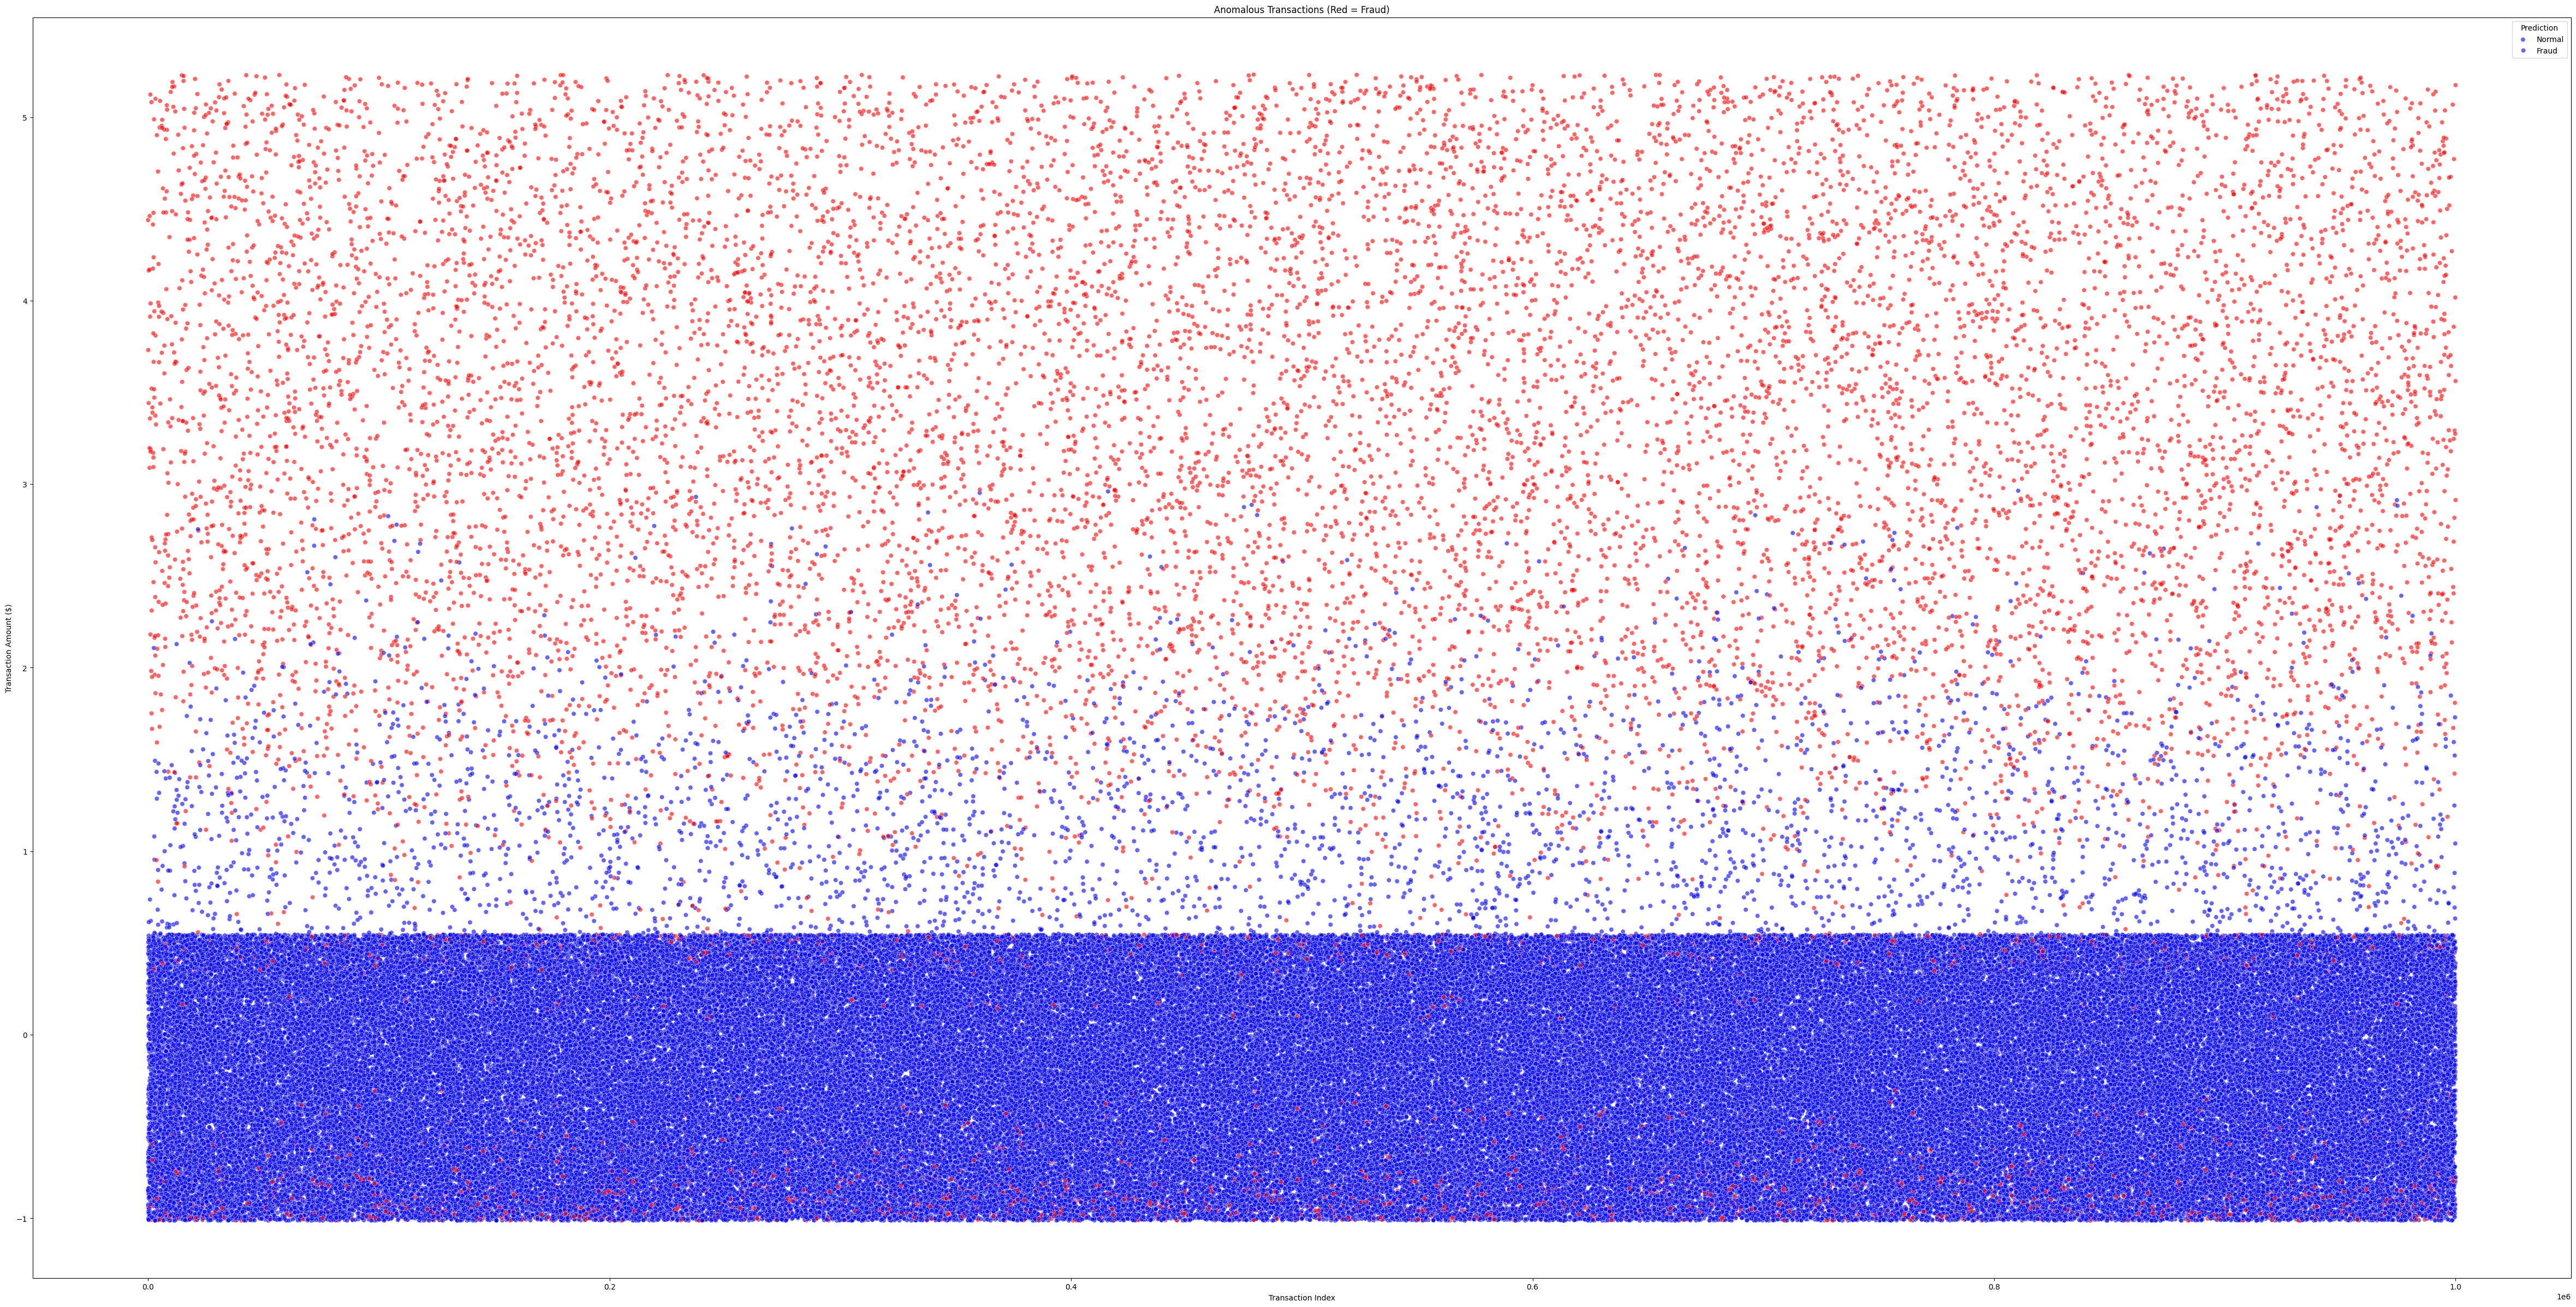

In [24]:
plt.figure(figsize=(60, 30))
sns.scatterplot(x=X_test.index, y=X_test["Amount"], hue=X_test["Predicted Fraud"], palette={0: "blue", 1: "red"}, alpha=0.6)
plt.title("Anomalous Transactions (Red = Fraud)")
plt.xlabel("Transaction Index")
plt.ylabel("Transaction Amount ($)")
plt.legend(title="Prediction", labels=["Normal", "Fraud"])
plt.show()

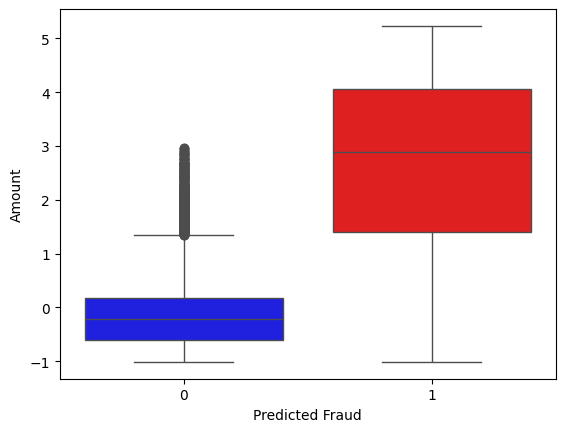

In [26]:
X_test["Predicted Fraud"] = X_test["Predicted Fraud"].astype(str)
sns.boxplot(x=X_test["Predicted Fraud"], y=X_test["Amount"],hue=X_test["Predicted Fraud"],palette={"0": "blue", "1": "red"},legend=False)
plt.show()

In [27]:
import joblib

In [28]:
joblib.dump(model, "isolation_forest.pkl")

['isolation_forest.pkl']